## SVM e PCA per classificazione volti

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [20]:
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [21]:
def plot_gallery(images, h, w, n_row=3, n_col=4, titles=None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='bilinear')
        if titles != None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [22]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [23]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [59]:
n_samples, h, w = lfw_people.images.shape

In [60]:
print(f'{n_samples:d} immagini {h:d}x{w:d} pixel')

1288 immagini 50x37 pixel


In [26]:
X = lfw_people.data

In [63]:
X.shape

(1288, 1850)

Immagini rappresentate come vettori di $h\times w$ elementi

In [67]:
n_features = X.shape[1]

In [68]:
t = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [69]:
print(f'Personaggi: {list(target_names)}')

Personaggi: ['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair']


In [70]:
n_classes

7

In [74]:
print("Dataset:")
print(f"{n_samples:d} elementi")
print(f"{n_features:d} features")
print(f"{n_classes:d} personaggi")

Dataset:
1288 elementi
1850 features
7 personaggi


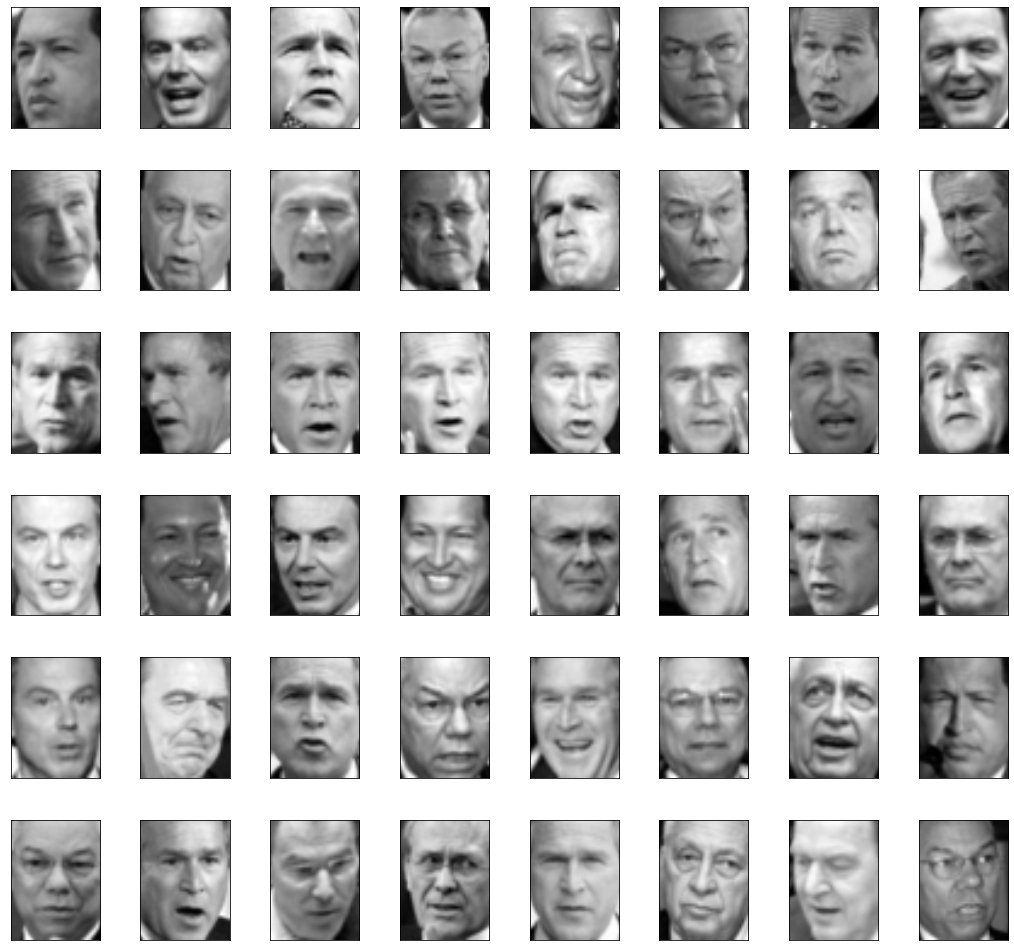

In [33]:
plot_gallery(X, h, w, n_row=6, n_col=8)

In [75]:
print('Frazione classi nel dataset')
for i,c in enumerate(target_names):
  nitems = np.where(t==i)[0].shape[0]
  print(f'{c:s}: {nitems:3d} occorrenze, ({nitems/n_samples*100:4.1f}%)')

Frazione classi nel dataset
Ariel Sharon:  77 occorrenze, ( 6.0%)
Colin Powell: 236 occorrenze, (18.3%)
Donald Rumsfeld: 121 occorrenze, ( 9.4%)
George W Bush: 530 occorrenze, (41.1%)
Gerhard Schroeder: 109 occorrenze, ( 8.5%)
Hugo Chavez:  71 occorrenze, ( 5.5%)
Tony Blair: 144 occorrenze, (11.2%)


Split in training e test set, con stratificazione

In [79]:
X_train, X_test, t_train, t_test = train_test_split(X, t, stratify=t, test_size=0.25)

In [80]:
print('Frazione classi nel training set')
for i,c in enumerate(target_names):
  nitems = np.where(t_train==i)[0].shape[0]
  print(f'{c:s}: {nitems:3d} occorrenze, ({nitems/n_samples*100:4.1f}%)')

Frazione classi nel training set
Ariel Sharon:  58 occorrenze, ( 4.5%)
Colin Powell: 177 occorrenze, (13.7%)
Donald Rumsfeld:  91 occorrenze, ( 7.1%)
George W Bush: 397 occorrenze, (30.8%)
Gerhard Schroeder:  82 occorrenze, ( 6.4%)
Hugo Chavez:  53 occorrenze, ( 4.1%)
Tony Blair: 108 occorrenze, ( 8.4%)


Normalizzazione dei valori delle features

In [82]:
scaler =StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Applica PCA per ridurre la dimensionalità: le componenti derivate (autovettori) sono indicate come _eigenfaces_

In [86]:
n_components = 50

print(f"Estrazione delle {n_components:d} eigenfaces più importanti da {n_samples:d} immagini")
print(f"La rappresentazione di un'immagine passa da {n_features:d} a {n_components:d} valori")
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

Estrazione delle 50 eigenfaces più importanti da 1288 immagini
La rappresentazione di un'immagine passa da 1850 a 50 valori


In [88]:
eigenfaces = pca.components_.reshape((n_components, h, w))

(50, 50, 37)

In [96]:
print(f"{n_components:d} autovettori di dimensione {n_features:d} riorganizzati come matrici {h:d}x{w:d}")

50 autovettori di dimensione 1850 riorganizzati come matrici 50x37


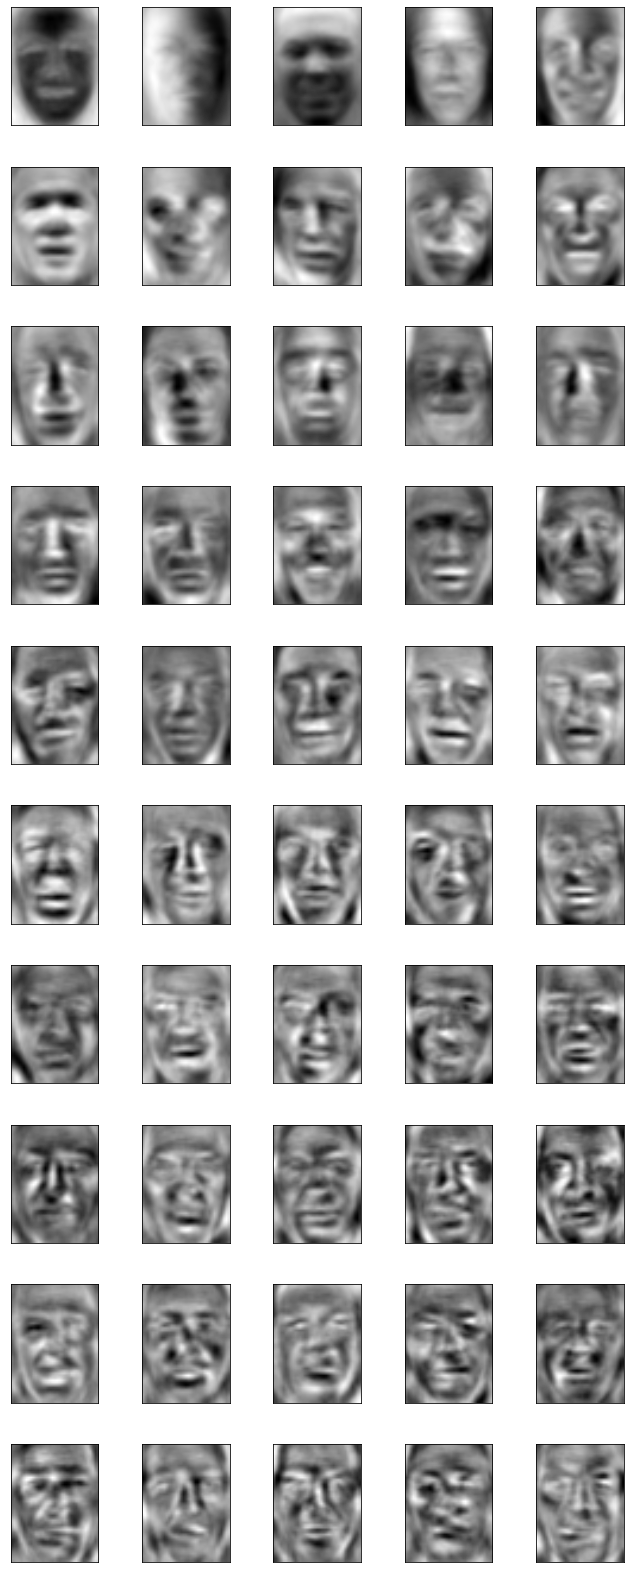

In [41]:
plot_gallery(eigenfaces, h, w, n_row=10, n_col=5)

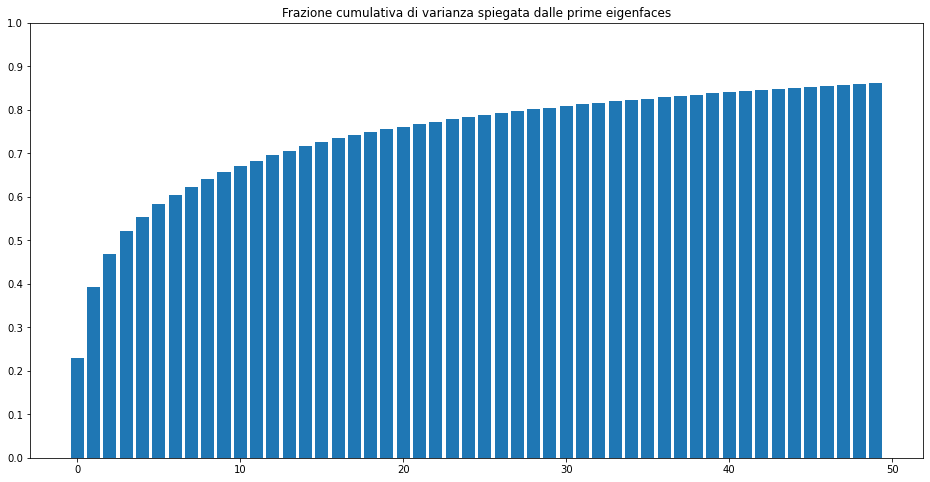

In [111]:
fig = plt.figure(figsize=(16,8))
plt.bar(range(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.linspace(0,1,11))
plt.title('Frazione cumulativa di varianza spiegata dalle prime eigenfaces');

Proiezione delle immagini nello spazio generato dagli autovettori

In [112]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Classificazione
Utilizzo di una SVM con kernel RBF. Grid search con 5-fold cross validation per model selection rispetto a $C$, parametro di controllo della componente di loss function relativa alle slack variables, e $\gamma$, parametro di controllo della varianza nel kernel RBF

In [129]:
param_grid = {'C': [10, 20], 'gamma': [0.01, 0.02], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, t_train)
best = clf.best_estimator_

In [145]:
print(f"Istanza di modello selezionata: C={clf.best_params_['C']:5.2f}, gamma={clf.best_params_['gamma']:3.2f}")

Istanza di modello selezionata: C=10.00, gamma=0.02


In [137]:
y_train = best.predict(X_train_pca)
print(classification_report(t_train, y_train, target_names=target_names))
print(confusion_matrix(t_train, y_train))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      1.00      1.00        58
     Colin Powell       1.00      1.00      1.00       177
  Donald Rumsfeld       1.00      1.00      1.00        91
    George W Bush       1.00      1.00      1.00       397
Gerhard Schroeder       1.00      1.00      1.00        82
      Hugo Chavez       1.00      1.00      1.00        53
       Tony Blair       1.00      1.00      1.00       108

         accuracy                           1.00       966
        macro avg       1.00      1.00      1.00       966
     weighted avg       1.00      1.00      1.00       966

[[ 58   0   0   0   0   0   0]
 [  0 177   0   0   0   0   0]
 [  0   0  91   0   0   0   0]
 [  0   0   0 397   0   0   0]
 [  0   0   0   0  82   0   0]
 [  0   0   0   0   0  53   0]
 [  0   0   0   0   0   0 108]]


In [138]:
y_test = best.predict(X_test_pca)
print(classification_report(t_test, y_test, target_names=target_names))
print(confusion_matrix(t_test, y_test))

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.79      0.86        19
     Colin Powell       0.87      0.92      0.89        59
  Donald Rumsfeld       0.96      0.73      0.83        30
    George W Bush       0.83      0.97      0.90       133
Gerhard Schroeder       0.79      0.70      0.75        27
      Hugo Chavez       0.91      0.56      0.69        18
       Tony Blair       0.90      0.78      0.84        36

         accuracy                           0.86       322
        macro avg       0.89      0.78      0.82       322
     weighted avg       0.87      0.86      0.86       322

[[ 15   3   0   1   0   0   0]
 [  1  54   0   3   0   1   0]
 [  0   0  22   6   1   0   1]
 [  0   3   1 129   0   0   0]
 [  0   0   0   6  19   0   2]
 [  0   1   0   5   2  10   0]
 [  0   1   0   5   2   0  28]]


In [143]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
p = Pipeline([('scaler', StandardScaler()), ('pca', PCA(svd_solver='randomized', whiten=True)), ('svc', SVC(kernel='rbf', class_weight='balanced'))])
param_grid = {'pca__n_components': [50,70], 'svc__C': [50, 80, 100], 'svc__gamma': [0.01, 0.02, 0.03], }
p = GridSearchCV(p, param_grid)
p = p.fit(X_train_pca, t_train)

In [144]:
print("Best estimator found by grid search:")
print(p.best_estimator_)
print(p.best_score_)
print(p.best_params_)

Best estimator found by grid search:
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 PCA(n_components=50, svd_solver='randomized', whiten=True)),
                ('svc', SVC(C=50, class_weight='balanced', gamma=0.01))])
0.842620586507131
{'pca__n_components': 50, 'svc__C': 50, 'svc__gamma': 0.01}


In [146]:
y_pred = p.predict(X_train_pca)
print(classification_report(t_train, y_pred, target_names=target_names))
print(confusion_matrix(t_train, y_pred))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      1.00      1.00        58
     Colin Powell       1.00      1.00      1.00       177
  Donald Rumsfeld       1.00      1.00      1.00        91
    George W Bush       1.00      1.00      1.00       397
Gerhard Schroeder       1.00      1.00      1.00        82
      Hugo Chavez       1.00      1.00      1.00        53
       Tony Blair       1.00      1.00      1.00       108

         accuracy                           1.00       966
        macro avg       1.00      1.00      1.00       966
     weighted avg       1.00      1.00      1.00       966

[[ 58   0   0   0   0   0   0]
 [  0 177   0   0   0   0   0]
 [  0   0  91   0   0   0   0]
 [  0   0   0 397   0   0   0]
 [  0   0   0   0  82   0   0]
 [  0   0   0   0   0  53   0]
 [  0   0   0   0   0   0 108]]


In [147]:
print("Predicting people's names on the test set")
y_pred = p.predict(X_test_pca)

print(classification_report(t_test, y_pred, target_names=target_names))
print(confusion_matrix(t_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.79      0.81        19
     Colin Powell       0.88      0.97      0.92        59
  Donald Rumsfeld       0.92      0.73      0.81        30
    George W Bush       0.90      0.94      0.92       133
Gerhard Schroeder       0.63      0.70      0.67        27
      Hugo Chavez       1.00      0.67      0.80        18
       Tony Blair       0.79      0.75      0.77        36

         accuracy                           0.86       322
        macro avg       0.85      0.79      0.81       322
     weighted avg       0.86      0.86      0.86       322

[[ 15   2   1   0   1   0   0]
 [  1  57   0   1   0   0   0]
 [  1   0  22   4   2   0   1]
 [  0   3   1 125   1   0   3]
 [  0   0   0   5  19   0   3]
 [  1   2   0   0   3  12   0]
 [  0   1   0   4   4   0  27]]


In [159]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[t_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

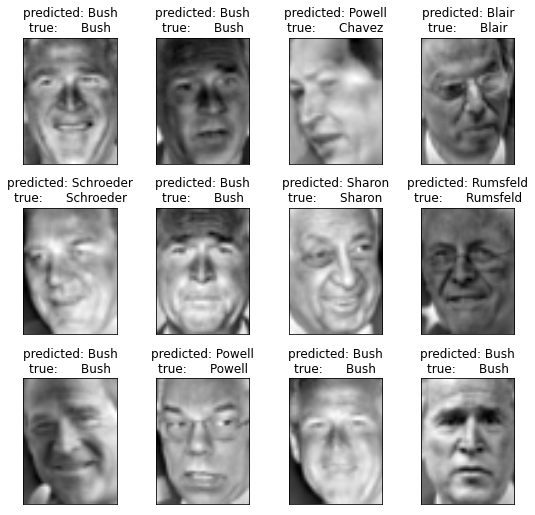

In [160]:
prediction_titles = [title(y_pred, t_test, target_names, i) for i in range(y_pred.shape[0])]

plot_gallery(X_test, h, w, titles=prediction_titles)